In [6]:
from datetime import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# df = pd.read_csv('washing_machine.csv')
df = pd.read_csv('sample.csv')
df['ts'] = pd.to_datetime(df['ts'], unit='ms')
df.set_index('ts', inplace=True, drop=True)
df = df.resample('20ms').max()
df = df[['pwrA']]
df = df.fillna(method='ffill')

df['event']=0
df.head()

,pwrA,event
ts,,
2021-04-16 21:28:00.000,105.162,0
2021-04-16 21:28:00.020,105.525,0
2021-04-16 21:28:00.040,105.773,0
2021-04-16 21:28:00.060,105.888,0
2021-04-16 21:28:00.080,105.789,0


In [8]:
interval = 20 # smart meter's internal interval
repint = 60000/interval # report interal in milliseconds
winlen = 5 # length of window (in number of samples)

buffer = [] # buffer aka window
thres = 100 #Watts
duration = 2*(1000/interval) # 2000 msec ~ aka 2seconds
report=np.nan
event=0

simulated = {}

In [9]:
counter = 0
for i in range(df.shape[0]):
    counter += 1
    if event==0:
        # if the buffer is not a full window, keep appending new samples. Else pop first item and append new item
        if len(buffer)<winlen:
            buffer.append(df['pwrA'].iloc[i])
        else:
            buffer.pop(0)
            buffer.append(df['pwrA'].iloc[i])
            
            # if there is a reported value to compare with, check absolute difference with current window
            if not math.isnan(report): 
                if np.abs(np.mean(buffer)-report)>thres:
                    # start transmitting at high frequency
                    df.at[df.index[i],'event']=1
                    simulated[df.index[i]] = [report,df['event'].iloc[i]]
                    event=1
                    counter=0
        
        # when report interval is reached, send average of window to cloud
        if counter == repint:
            report = np.mean(buffer)
            simulated[df.index[i]] = [report,df['event'].iloc[i]]
            counter=0
            
    # on event mode, continuous streaming
    else:
        buffer.pop(0)
        buffer.append(df['pwrA'].iloc[i])
        
        if counter == duration: # if 2 seconds have passed return to low sampling rate
            event = 0
            counter=0
            report = np.mean(buffer)
            simulated[df.index[i]] = [report,df['event'].iloc[i]]
            buffer = []   
        else:
            simulated[df.index[i]] = [df['pwrA'].iloc[i],df['event'].iloc[i]]
        


In [10]:
sim_df = pd.DataFrame.from_dict(simulated, orient='index')
sim_df.rename(columns={0:'pwrA', 1:'event'}, inplace=True)
sim_df.head()

,pwrA,event
2021-04-16 21:28:59.980,123.8132,0
2021-04-16 21:29:15.100,123.8132,1
2021-04-16 21:29:15.120,227.0330,0
2021-04-16 21:29:15.140,227.9580,0
2021-04-16 21:29:15.160,229.0140,0


<AxesSubplot:>

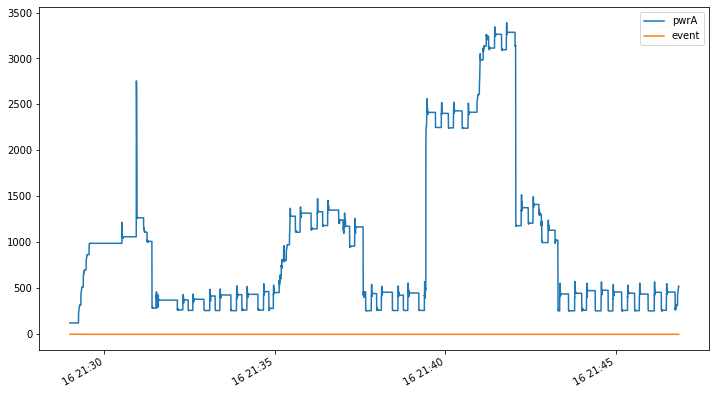

In [11]:
sim_df.iloc[:10000].plot(figsize=[12,7])

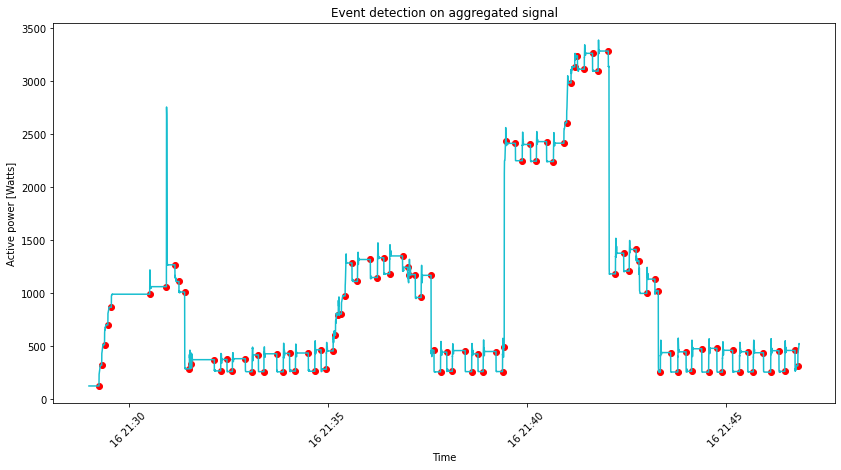

In [46]:
tmp = sim_df.iloc[:10000].copy()
fig, ax1 = plt.subplots(figsize=(14, 7.0))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
color = 'tab:cyan'
ax1.plot(tmp.index, tmp['pwrA'], '-', color=color)
ax1.set_ylabel('Active power [Watts]',)
ax1.set_xlabel('Time')
ax1.set_title('Event detection on aggregated signal')

cl0 = tmp['event']==0
cl1 = tmp['event']==1

ax1.scatter(tmp.index[cl1], tmp['pwrA'][cl1], color='red') 

